In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [3]:
name_dataset = 'cennosti'

### load data

In [4]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(8420, 7)
CPU times: user 2.08 s, sys: 29.5 ms, total: 2.11 s
Wall time: 2.26 s


In [5]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/sony/,NaN,Мир,Sony выдает лицензии на использование технолог...,Корпорация Sony выдала лицензии на использован...,Ценности
1,1999-10-07 12:00:00,https://lenta.ru/news/1999/10/07/vodka/,NaN,Экономика,"В Уфе выпустили водку ""Беспохмельную""","Уфимский спиртоводочный комбинат ""Золотой век""...",Ценности


### preprocess

* get dates

In [6]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 128 ms, sys: 3.81 ms, total: 132 ms
Wall time: 143 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [7]:
import preprocessing_tools as pr

In [8]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 1.79 s, sys: 18.5 ms, total: 1.81 s
Wall time: 1.89 s


In [9]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/sony/,NaN,Мир,Sony выдает лицензии на использование технолог...,корпорация sony выдала лицензии на использован...,Ценности,"[(1999, 10, 06)]",1999,10
1,1999-10-07 12:00:00,https://lenta.ru/news/1999/10/07/vodka/,NaN,Экономика,"В Уфе выпустили водку ""Беспохмельную""",уфимский спиртоводочный комбинат золотой век о...,Ценности,"[(1999, 10, 07)]",1999,10


* cleanedNames

In [10]:
from cleanedNames import KeyProc
cn = KeyProc()

In [11]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 16.1 s, sys: 79.2 ms, total: 16.2 s
Wall time: 17.3 s


* lemmatization

In [12]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 45 s, sys: 75.4 ms, total: 45.1 s
Wall time: 48.1 s


* add docID

In [13]:
df['docID'] = list(range(df.shape[0]))

In [14]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[корпорация, sony, выдать, лицензия, использов..."
1,1,1999,10,"[уфимский, спиртоводочный, комбинат, золотой, ..."


In [15]:
print(df.shape)
df.isnull().sum()

(8420, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [16]:
df.year.min()

1999

## model

* prepare

In [17]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 160 ms, sys: 15.1 ms, total: 175 ms
Wall time: 224 ms


In [18]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [19]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/cennosti", num_batches=9)
CPU times: user 6.22 s, sys: 269 ms, total: 6.49 s
Wall time: 6.61 s


In [20]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [21]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=9c1b0d81-206a-43c2-9f9e-1fa0cbcb3393, num_entries=9351)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [23]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.1805819422006607
	SparsityPhiScore: 0.27922147512435913
	PerplexityScore: 3309.599853515625
	time: 0:01:06.079346
#topic 3.........
	SparsityThetaScore: 0.3218131363391876
	SparsityPhiScore: 0.39995720982551575
	PerplexityScore: 2907.879638671875
	time: 0:00:13.343918
#topic 4.........
	SparsityThetaScore: 0.3861045241355896
	SparsityPhiScore: 0.4884771704673767
	PerplexityScore: 2684.926025390625
	time: 0:00:09.688137
#topic 5.........
	SparsityThetaScore: 0.44969120621681213
	SparsityPhiScore: 0.5426799058914185
	PerplexityScore: 2535.3779296875
	time: 0:00:09.626879
#topic 6.........
	SparsityThetaScore: 0.509817898273468
	SparsityPhiScore: 0.5759455561637878
	PerplexityScore: 2337.489013671875
	time: 0:00:10.312022
#topic 7.........
	SparsityThetaScore: 0.5537835359573364
	SparsityPhiScore: 0.6088271737098694
	PerplexityScore: 2217.860595703125
	time: 0:00:10.585638
#topic 8.........
	SparsityThetaScore: 0.5859115123748779
	SparsityPhiScore:

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

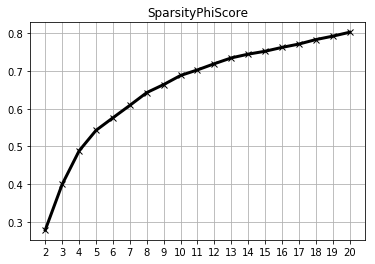

In [24]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [25]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [26]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.3: 1, 0.4: 1, 0.5: 2, 0.6: 4, 0.7: 9, 0.8: 1}

Text(0.5, 1.0, 'SparsityThetaScore')

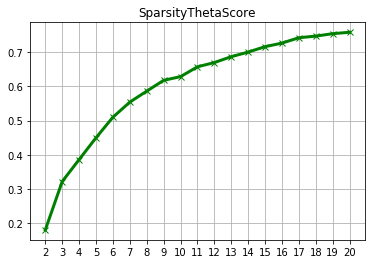

In [27]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [28]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.3, 0.4, 0.5, 0.6, 0.7]

In [29]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.3: 2, 0.4: 1, 0.5: 3, 0.6: 6, 0.7: 6}

Text(0.5, 1.0, 'PerplexityScore')

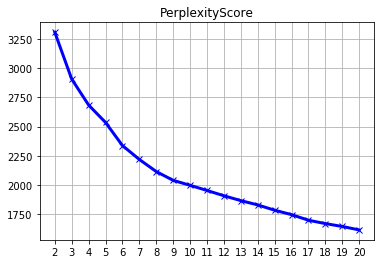

In [30]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [31]:
perplexity

[3309.599853515625,
 2907.879638671875,
 2684.926025390625,
 2535.3779296875,
 2337.489013671875,
 2217.860595703125,
 2114.16015625,
 2038.4696044921875,
 1996.2071533203125,
 1951.7471923828125,
 1906.5108642578125,
 1864.5870361328125,
 1827.8912353515625,
 1782.4200439453125,
 1744.39892578125,
 1696.3912353515625,
 1667.57177734375,
 1642.751953125,
 1613.23046875]

### select the best model

In [32]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.3: 1, 0.4: 1, 0.5: 2, 0.6: 4, 0.7: 9, 0.8: 1}
d_stheta: {0.1: 1, 0.3: 2, 0.4: 1, 0.5: 3, 0.6: 6, 0.7: 6}


In [33]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


### print top words for each topics

In [35]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['украшение' 'бриллиант' 'ювелирный' 'золото' 'камень' 'кольцо' 'cartier'
 'браслет' 'драгоценный' 'tiffany']
topic_1: ['миллион' 'аукцион' 'продать' 'торг' 'выставить' 'аукционный'
 'принадлежать' 'фунт' 'стоимость' 'президент']
topic_2: ['человек' 'заявить' 'организация' 'and' 'to' 'of' 'право' 'for' 'in'
 'акция']
topic_3: ['выставка' 'москва' 'мероприятие' 'машина' 'международный' 'рамка'
 'jaguar' 'rover' 'rollsroyce' 'модификация']
topic_4: ['сумка' 'красный' 'цвет' 'украсить' 'оттенок' 'туфля' 'логотип'
 'фирменный' 'мех' 'подошва']
topic_5: ['яхта' 'метр' 'проект' 'судно' 'верфь' 'отель' 'площадь' 'километр'
 'владелец' 'интерьер']
topic_6: ['аромат' 'adidas' 'кроссовок' 'флакон' 'нота' 'reebok' 'дух' 'dior'
 'рэпер' 'originals']
topic_7: ['премия' 'группа' 'dolce' 'gabbana' 'награда' 'олимпийский' 'церемония'
 'искусство' 'хороший' 'игра']
topic_8: ['часовой' 'корпус' 'швейцарский' 'циферблат' 'механизм' 'мануфактура'
 'калибр' 'экземпляр' 'ремешок' 'оснастить']
topic

### get topics-docs matrix

shape theta: (20, 8420)


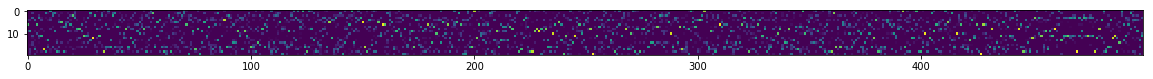

In [36]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [37]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
8000,0.000000,0.000000,0.059268,0.000000,0.172666,0.0,0.000000,0.0,0.000000,0.0,0.090031,0.0,0.000000,0.000000,0.184671,0.308292,0.108836,0.000000,0.000000,0.076236
8001,0.000000,0.015092,0.000000,0.000000,0.055863,0.0,0.016035,0.0,0.000000,0.0,0.071132,0.0,0.020901,0.000000,0.276473,0.531667,0.012837,0.000000,0.000000,0.000000
8002,0.000000,0.054980,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.348673,0.000000,0.000000,0.000000,0.596347
8003,0.039726,0.000000,0.000000,0.000000,0.276715,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.175985,0.000000,0.086299,0.000000,0.205534,0.000000,0.215741
8004,0.139391,0.000000,0.000000,0.100832,0.100625,0.0,0.000000,0.0,0.042136,0.0,0.000000,0.0,0.033739,0.010882,0.518291,0.000000,0.000000,0.000000,0.054104,0.000000


## DataViz

In [38]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.037727,0.000000,0.000000,0.058025,0.0,0.0,0.01951,...,0.0,0.006291,0.415111,0.000000,0.463338,0.000000,0.0,0.0,0.000000,0.0
1,1,1999,10,0.000000,0.363424,0.000000,0.000000,0.0,0.0,0.00000,...,0.0,0.000000,0.000000,0.160196,0.476380,0.000000,0.0,0.0,0.000000,0.0
2,2,1999,10,0.052385,0.220040,0.210182,0.000000,0.0,0.0,0.00000,...,0.0,0.090952,0.000000,0.000000,0.426441,0.000000,0.0,0.0,0.000000,0.0
3,3,1999,10,0.000000,0.133173,0.283744,0.243093,0.0,0.0,0.00000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.339991,0.0,0.0,0.000000,0.0
4,4,1999,12,0.000000,0.148014,0.697524,0.000000,0.0,0.0,0.00000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.037251,0.0


In [39]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (209, 20)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 9      0.000000  0.000000  0.476834  0.014146  0.000000  0.000000   
     10     0.090111  0.716637  0.493926  0.301117  0.000000  0.000000   
     11     0.000000  0.209692  0.533972  0.000000  0.000000  0.000000   
     12     0.000000  0.646506  1.344077  0.438237  0.008757  0.048669   
2000 1      0.014331  0.107975  0.069376  0.000000  0.000000  0.011673   

            topic_6   topic_7   topic_8  topic_9  topic_10  topic_11  \
year month                                                             
1999 9      0.00000  0.000000  0.000000      0.0  0.000000  0.000000   
     10     0.01951  0.000000  0.000000      0.0  0.000000  0.097243   
     11     0.00000  0.000000  0.000000      0.0  0.000000  0.027006   
     12     0.00000  0.236182  0.082184      0.0  0.039154  0.816147   
2000 1      0.00000  0.000000  0.000000      0.0  0.000303  0.000000   

            topic_12  topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                               
1999 9      0.259538  0.000000  0.197325  0.000000  0.000000  0.022712   
     10     0.415111  0.160196  1.366159  0.339991  0.000000  0.000000   
     11     0.000000  0.042569  0.099826  0.086934  0.000000  0.000000   
     12     0.000000  0.000000  0.302836  0.000000  0.000000  0.000000   
2000 1      0.000000  0.000000  0.000000  0.427542  0.176138  0.000000   

            topic_18  topic_19  
year month                      
1999 9      0.029446  0.000000  
     10     0.000000  0.000000  
     11     0.000000  0.000000  
     12     0.037251  0.000000  
2000 1      0.000000  0.192663

### straightforward matrix heatmap

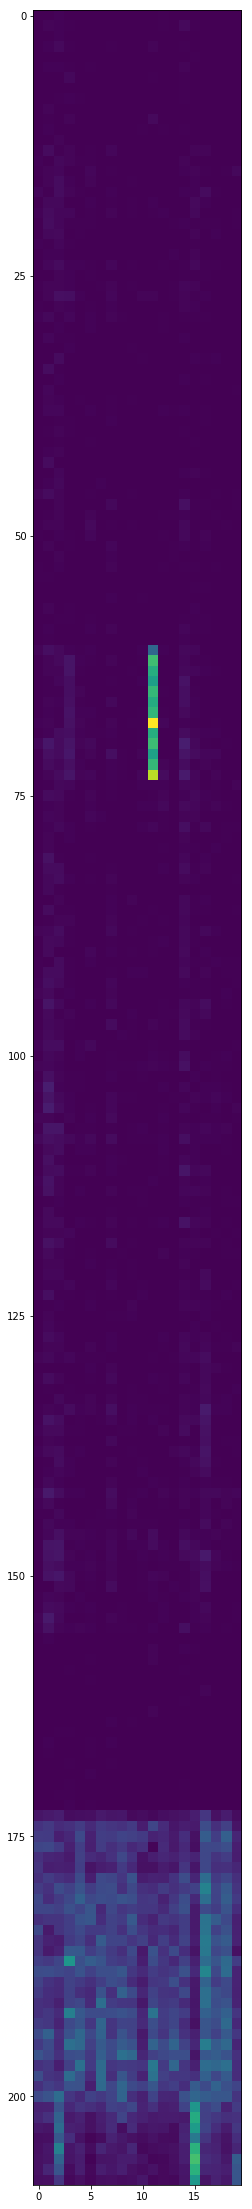

In [40]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [41]:
import pygal
from IPython.display import SVG, HTML

In [42]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [43]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [45]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [46]:
import joypy # !pip install joypy

In [47]:
print(joined.shape)
joined.head()

(8420, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.037727,0.000000,0.000000,0.058025,0.0,0.0,0.01951,...,0.0,0.006291,0.415111,0.000000,0.463338,0.000000,0.0,0.0,0.000000,0.0
1,1,1999,10,0.000000,0.363424,0.000000,0.000000,0.0,0.0,0.00000,...,0.0,0.000000,0.000000,0.160196,0.476380,0.000000,0.0,0.0,0.000000,0.0
2,2,1999,10,0.052385,0.220040,0.210182,0.000000,0.0,0.0,0.00000,...,0.0,0.090952,0.000000,0.000000,0.426441,0.000000,0.0,0.0,0.000000,0.0
3,3,1999,10,0.000000,0.133173,0.283744,0.243093,0.0,0.0,0.00000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.339991,0.0,0.0,0.000000,0.0
4,4,1999,12,0.000000,0.148014,0.697524,0.000000,0.0,0.0,0.00000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.037251,0.0


In [48]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.037727,0.000000,0.000000,0.058025,0.0,0.0,...,0.006291,0.415111,0.000000,0.463338,0.000000,0.0,0.0,0.000000,0.0,1999-10-01
1,1,1,1999,10,0.000000,0.363424,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.160196,0.476380,0.000000,0.0,0.0,0.000000,0.0,1999-10-01
2,2,2,1999,10,0.052385,0.220040,0.210182,0.000000,0.0,0.0,...,0.090952,0.000000,0.000000,0.426441,0.000000,0.0,0.0,0.000000,0.0,1999-10-01
3,3,3,1999,10,0.000000,0.133173,0.283744,0.243093,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.339991,0.0,0.0,0.000000,0.0,1999-10-01
4,4,4,1999,12,0.000000,0.148014,0.697524,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.037251,0.0,1999-12-01


In [49]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(202080, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-10-01,index,2.0
3,1999-10-01,index,3.0
4,1999-12-01,index,4.0


In [50]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(168400, 3)


topic_11    8420
topic_10    8420
topic_4     8420
topic_17    8420
topic_7     8420
topic_14    8420
topic_0     8420
topic_16    8420
topic_6     8420
topic_18    8420
topic_8     8420
topic_12    8420
topic_3     8420
topic_15    8420
topic_5     8420
topic_13    8420
topic_9     8420
topic_2     8420
topic_19    8420
topic_1     8420
Name: topic, dtype: int64

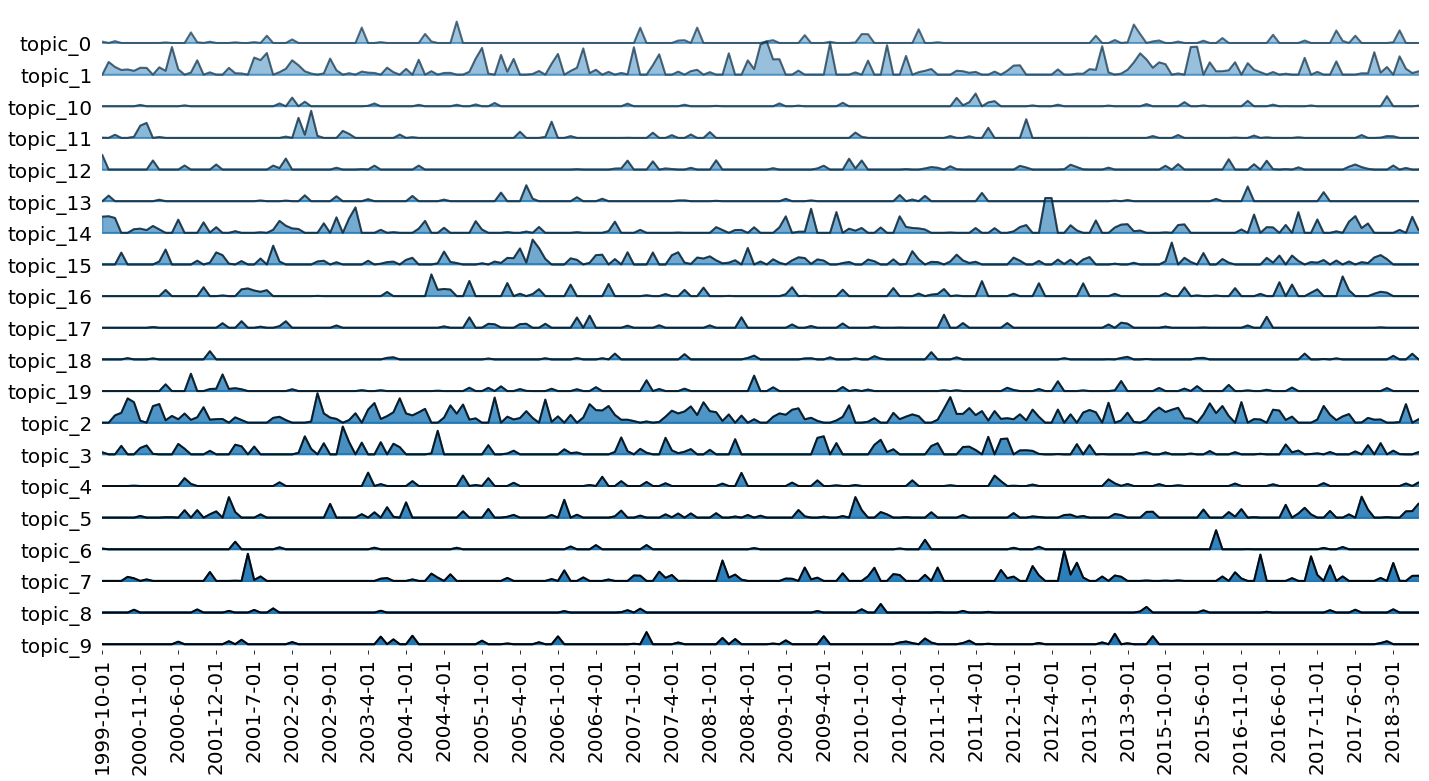

In [51]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [52]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")